# BIAS results from CMA ES

In [11]:
from config import bias_cmaes_explainer, cma_features_bias
import pandas as pd

features = [
    "active",
    "covariance",
    "elitist",
    "orthogonal",
    "sequential",
    "threshold",
    "sigma",
    "bound_correction",
    "mirrored",
    "base_sampler",
    "weights_option",
    "local_restart",
    "step_size_adaptation",
]

In [12]:
bias = pd.read_csv("cma-bias.csv")
bias = bias.drop(columns=["Unnamed: 0"])
bias[features] = bias[features].fillna("nan")

In [13]:
bias

,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,weights_option,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters
0,False,False,False,False,False,False,False,nan,nan,sobol,default,nan,csa,20,5,2.235770e-09,0.000000e+00,2.363955e-01,7.522186e-31,0.763605
1,False,False,False,False,False,False,False,nan,nan,sobol,equal,nan,csa,20,5,7.485372e-08,1.689857e-07,1.860950e-08,3.007503e-28,1.000000
2,False,False,False,False,False,False,False,nan,nan,sobol,1/2^lambda,nan,csa,20,5,0.000000e+00,0.000000e+00,1.304259e-29,2.000000e-01,0.800000
3,False,False,False,False,False,True,False,nan,nan,sobol,default,nan,csa,20,5,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e-01,0.600000
4,False,False,False,False,False,True,False,nan,nan,sobol,equal,nan,csa,20,5,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e-01,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435451,True,True,True,True,True,False,True,uniform,mirrored pairwise,halton,equal,BIPOP,lpxnes,20,5,1.063410e-11,9.485503e-01,1.367079e-15,1.325684e-26,0.051450
435452,True,True,True,True,True,False,True,uniform,mirrored pairwise,halton,1/2^lambda,BIPOP,lpxnes,20,5,1.725203e-09,9.064817e-01,1.178766e-13,1.382055e-26,0.093518
435453,True,True,True,True,True,True,True,uniform,mirrored pairwise,halton,default,BIPOP,lpxnes,20,5,1.601124e-02,8.763663e-01,8.489967e-05,2.355851e-09,0.107538
435454,True,True,True,True,True,True,True,uniform,mirrored pairwise,halton,equal,BIPOP,lpxnes,20,5,1.171107e-06,8.515029e-01,3.259577e-13,1.142351e-22,0.148496


In [14]:
# Decision tree rules extraction

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import numpy as np
from sklearn.model_selection import cross_val_score

X = pd.get_dummies(bias[features])
y_hat = bias[["unif", "centre", "disc", "bounds", "clusters"]].copy()
y = np.argmax(y_hat, axis=1)
y_bias = y_hat['unif']

In [15]:
# algs
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            if (threshold == 0.5):
                p1 += [f"({name} == False)"]
            else:
                p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            if (threshold == 0.5):
                p2 += [f"({name} == True)"]
            else:
                p2 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [16]:
#train the tree
clf = DecisionTreeClassifier(max_depth=6, random_state=42)
model = clf.fit(X, y)
cross_val_score(model, X, y, cv=10)

array([0.83426721, 0.74491342, 0.84503743, 0.75428283, 0.76137877,
       0.77743076, 0.75039614, 0.85768745, 0.75606843, 0.78789758])

In [ ]:
import dtreeviz
for idx, biastype in enumerate(list(y_hat.columns)):
    
    y_bias = y == idx
    model = DecisionTreeClassifier(max_depth=6, random_state=42)
    model.fit(X, y_bias)
    print(cross_val_score(model, X, y_bias, cv=3))

    viz_model = dtreeviz.model(model, X, y_bias,
        target_name=biastype,
        feature_names=X.columns,
        class_names=["False", "True"] 
    )
    v = viz_model.view(scale=1.0)
    v.save(f"bias_results/cmabias_{biastype}-tree.svg")

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

[0.89330495 0.89997382 0.89710097]


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ar

[0.72822972 0.73008984 0.79639964]


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ar

[0.62147266 0.97949735 0.99098187]


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ar

[0.96863977 0.96660053 0.96460951]


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ar

[0.85616457 0.86013283 0.86696015]


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ar

In [17]:
rules = get_rules(clf, X.columns, y_hat.columns)
for r in rules:
    print(r)

if (bound_correction_nan == False) and (bound_correction_saturate == False) and (elitist == False) and (step_size_adaptation_xnes == False) and (step_size_adaptation_lpxnes == False) and (step_size_adaptation_mxnes == False) then class: centre (proba: 96.83%) | based on 82,944 samples
if (bound_correction_nan == False) and (bound_correction_saturate == False) and (elitist == True) and (covariance == False) and (step_size_adaptation_mxnes == False) and (threshold == False) then class: centre (proba: 46.97%) | based on 31,104 samples
if (bound_correction_nan == False) and (bound_correction_saturate == False) and (elitist == True) and (covariance == True) and (step_size_adaptation_msr == False) and (threshold == True) then class: centre (proba: 97.68%) | based on 31,104 samples
if (bound_correction_nan == False) and (bound_correction_saturate == False) and (elitist == True) and (covariance == False) and (step_size_adaptation_mxnes == False) and (threshold == True) then class: unif (proba:

In [18]:
#now use shap
import shap
import xgboost
from sklearn.model_selection import train_test_split

#y_bias = y_hat['unif']
#y_bias = y_bias.fillna(0)
X = X.fillna(0)
for idx, biastype in enumerate(list(y_hat.columns)):
    y_bias = y == idx

    # create a train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_bias, test_size=0.2, random_state=42)
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    xgb_full = xgboost.DMatrix(X, label=y_bias)

    # params = {"max_depth": 4, "objective": "binary:logistic", "subsample": 0.5} #"eta": 0.002, 
    # model_train = xgboost.train(
    #     params, xgb_train, 1000, evals=[(xgb_test, "test")], verbose_eval=1000
    # )

    # train final model on the full data set
    params = {"max_depth": 4, "objective": "binary:logistic", "subsample": 0.5} #"eta": 0.002, 
    model = xgboost.train(
        params, xgb_full, 2000, evals=[(xgb_full, "test")], verbose_eval=500
    )

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)
    order = list(X.columns.values)
    col2num = {col: i for i, col in enumerate(X.columns)}
    order = list(map(col2num.get, order))
    shap.plots.beeswarm(
                        explainer(X),
                        show=False,
                        max_display=len(X.columns),
                        order=order,
                        color=plt.get_cmap("viridis"),
                    )
    plt.tight_layout()
    plt.xlabel(
        f"Module option contributions for {biastype}"
    )
    plt.savefig(f"bias_results/shapbias-{biastype}-10.png")
    plt.show()
    plt.clf()
    
    if False:
        ## interaction plots
        #pred_interactions
        shap_interaction_values = explainer.shap_interaction_values(
            X, tree_limit=20
        )
        shap.summary_plot(shap_interaction_values, X, show=False, color=plt.get_cmap("viridis"))
        plt.savefig(f"bias_results/shapbias-interactions-{biastype}.png")
        plt.show()
        plt.clf()

        for hyper_parameter in range(len(X.columns)):
            shap.dependence_plot(
                hyper_parameter,
                shap_values,
                X,
                show=False,
                cmap=plt.get_cmap("viridis"),
            )
            plt.tight_layout()
            plt.savefig(
                f"bias_results/shapbias-{biastype}-pdp-{hyper_parameter}.png"
            )

            plt.show()
            plt.clf()


[0]	test-logloss:0.51578
[500]	test-logloss:0.06523


In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

#scope rules
from skrules import SkopeRules
clf = SkopeRules(max_depth_duplication=3,
                 n_estimators=100,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=list(X.columns))

for idx, biastype in enumerate(list(y_hat.columns)):
    clf.fit(X, y == idx)
    rules = clf.rules_[0:10]
    print("Rules for", biastype)
    for rule in rules:
        print(rule)
    print()
    print(20*'=')
    print()

/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Rules for unif
('covariance <= 0.5 and elitist > 0.5 and bound_correction_saturate <= 0.5', (0.3842936452687813, 0.6768266514023527, 200))




/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Rules for centre
('covariance > 0.5 and bound_correction_uniform <= 0.5 and bound_correction_saturate <= 0.5', (0.7251398063094195, 0.394110026661105, 200))
('covariance <= 0.5 and elitist <= 0.5 and bound_correction_saturate <= 0.5', (0.7757749779428367, 0.26351037966685903, 200))
('covariance > 0.5 and bound_correction_uniform > 0.5 and bound_correction_saturate <= 0.5', (0.9273461764104731, 0.12600591942881725, 200))




/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Rules for disc




/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Rules for bounds
('covariance <= 0.5 and elitist > 0.5 and bound_correction_saturate > 0.5', (0.636419430756297, 0.5016657722670701, 200))




/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Rules for clusters
('bound_correction_uniform <= 0.5 and bound_correction_cotn <= 0.5 and bound_correction_mirror <= 0.5', (0.3569149826680692, 0.8641740794783734, 130))
('bound_correction_toroidal <= 0.5 and bound_correction_uniform <= 0.5 and bound_correction_cotn <= 0.5', (0.3567884301977001, 0.8639518789722901, 70))




unif
0.09429117948729598
39313 0.09028007422104645
centre
0.5595314060804721
261261 0.5999710648148148
disc
0.013400737333029836
3439 0.007897468400940624
bounds
0.05405190388833332
22190 0.05095807613168724
clusters
0.27872477465182394
91578 0.21030368165784832


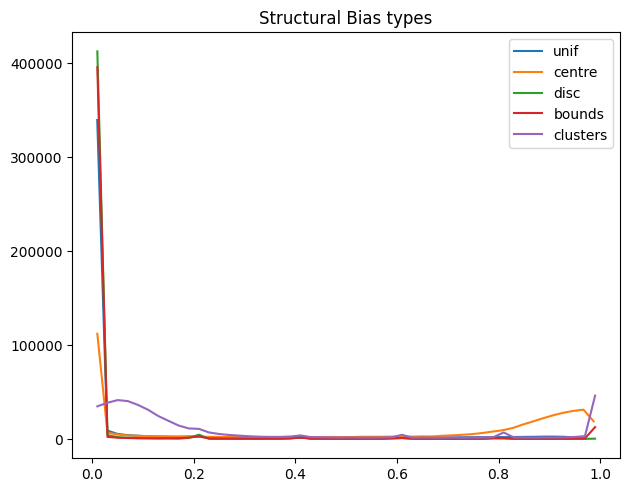

0.008384404532156574
18144


In [ ]:
#subselection analysis without bound correction

for idx, biastype in enumerate(list(y_hat.columns)):
    #y_bias = y == idx
        # Histogram
    heights,bins = np.histogram(bias[biastype].fillna(0.0),bins=50)
    print(biastype)
    print(bias[biastype].mean())
    print(len(bias[bias[biastype]  > 0.5]), len(bias[bias[biastype]  > 0.5]) / float(len(bias)))
    # Normalize
    #heights = heights/float(sum(heights))
    binMids=bins[:-1]+np.diff(bins)/2.
    plt.plot(binMids,heights, label=biastype)
plt.legend()
plt.tight_layout()
plt.title("Structural Bias types")
plt.show()


bias_sub = bias[(bias["bound_correction"].isna()) & (bias["elitist"] == False) & (bias["covariance"] == True)].copy()
print(bias_sub['unif'].mean())
print(len(bias_sub))



[0]	test-logloss:0.43808
[1000]	test-logloss:0.00069
[2000]	test-logloss:0.00064
[3000]	test-logloss:0.00060
[4000]	test-logloss:0.00060
[4999]	test-logloss:0.00057


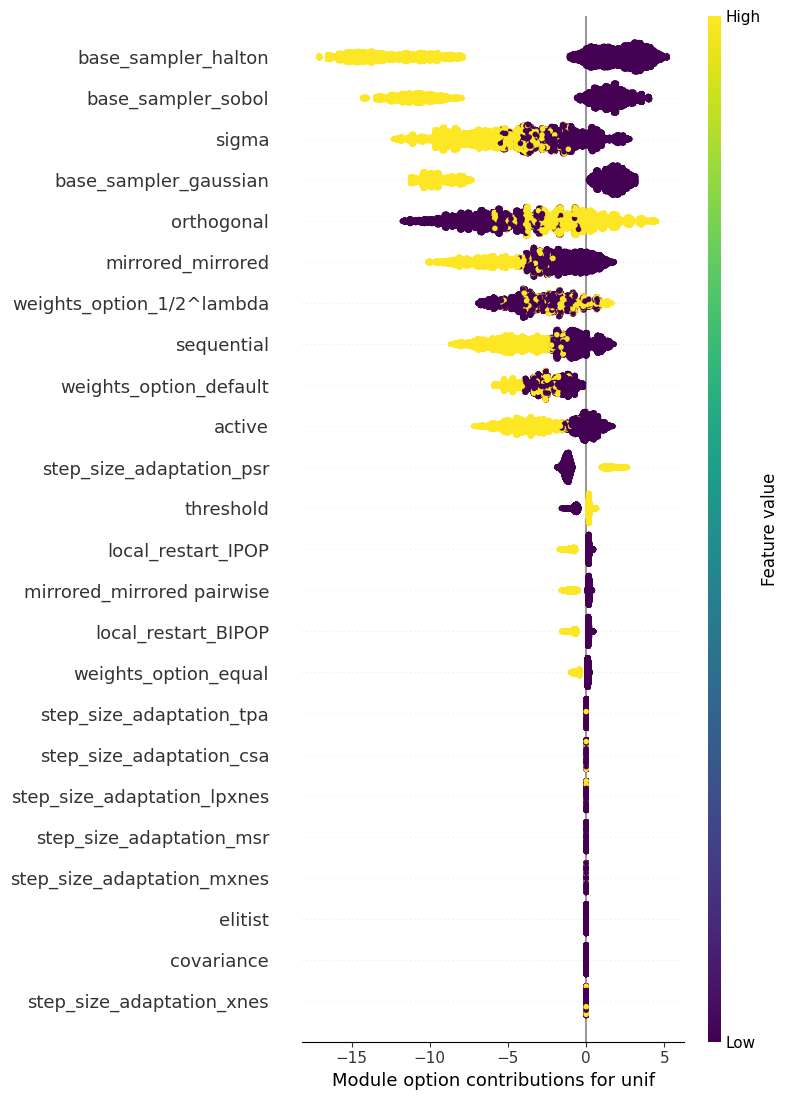

<Figure size 640x480 with 0 Axes>

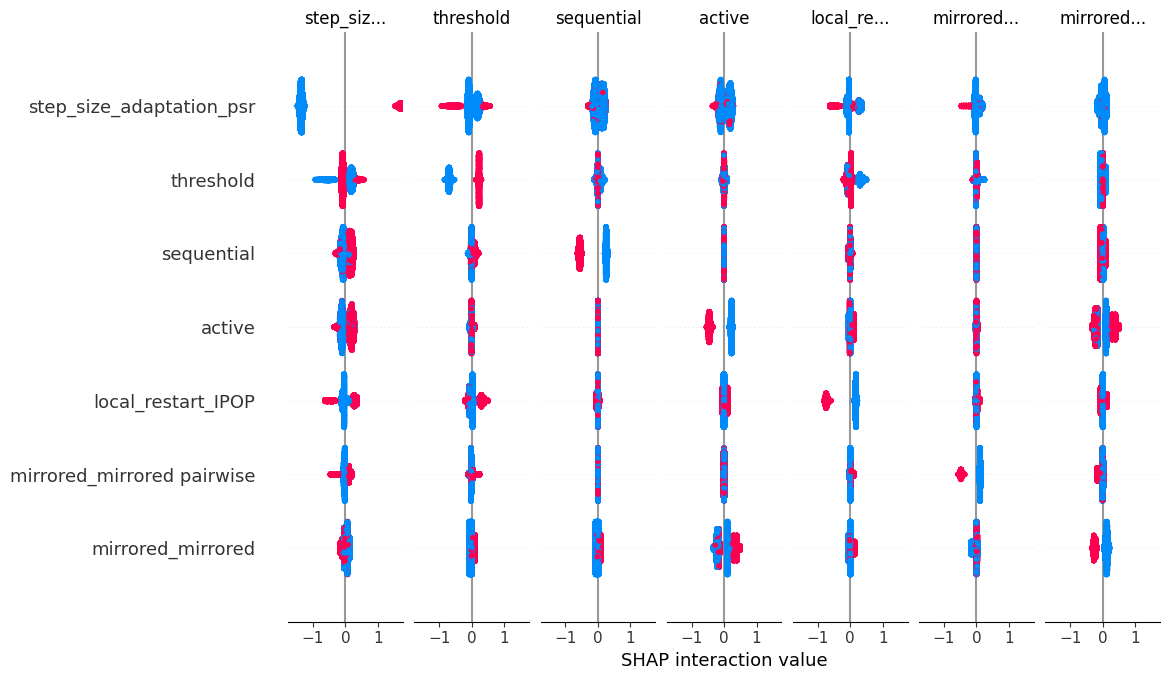

[0]	test-logloss:0.51245
[1000]	test-logloss:0.02453
[2000]	test-logloss:0.01679
[3000]	test-logloss:0.01290
[4000]	test-logloss:0.01054
[4999]	test-logloss:0.00848


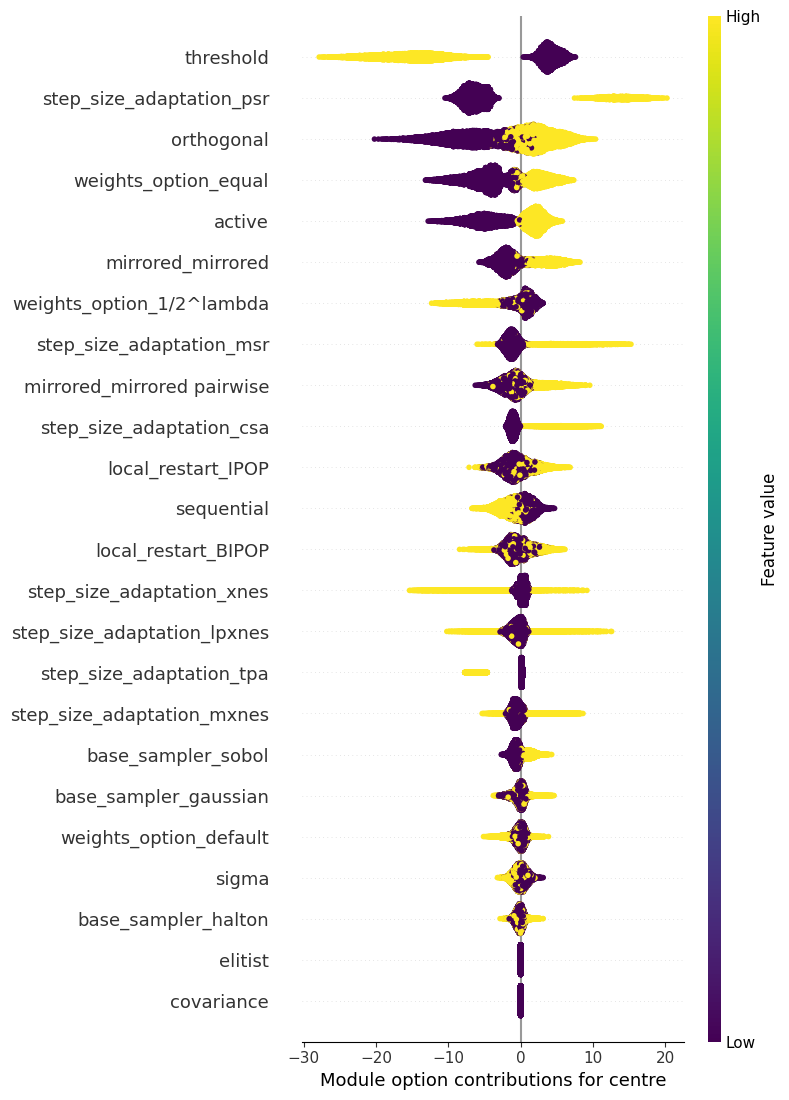

<Figure size 640x480 with 0 Axes>

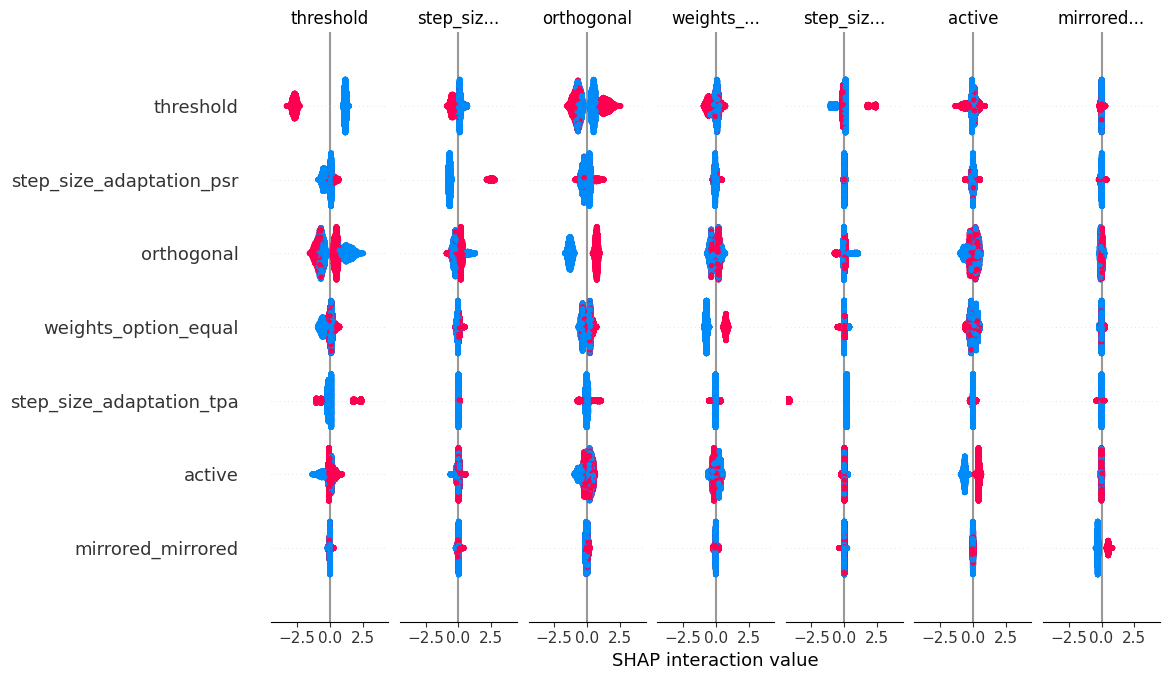

[0]	test-logloss:0.51097
[1000]	test-logloss:0.11386
[2000]	test-logloss:0.09850
[3000]	test-logloss:0.08958
[4000]	test-logloss:0.08470
[4999]	test-logloss:0.07991


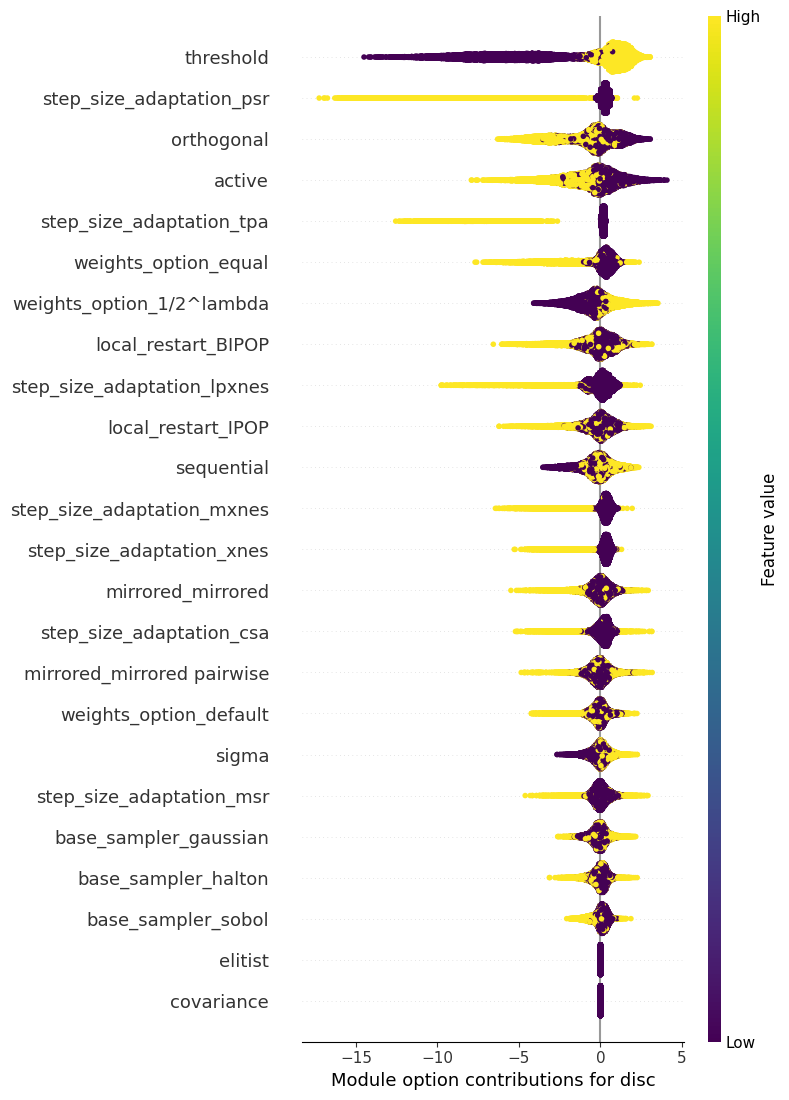

<Figure size 640x480 with 0 Axes>

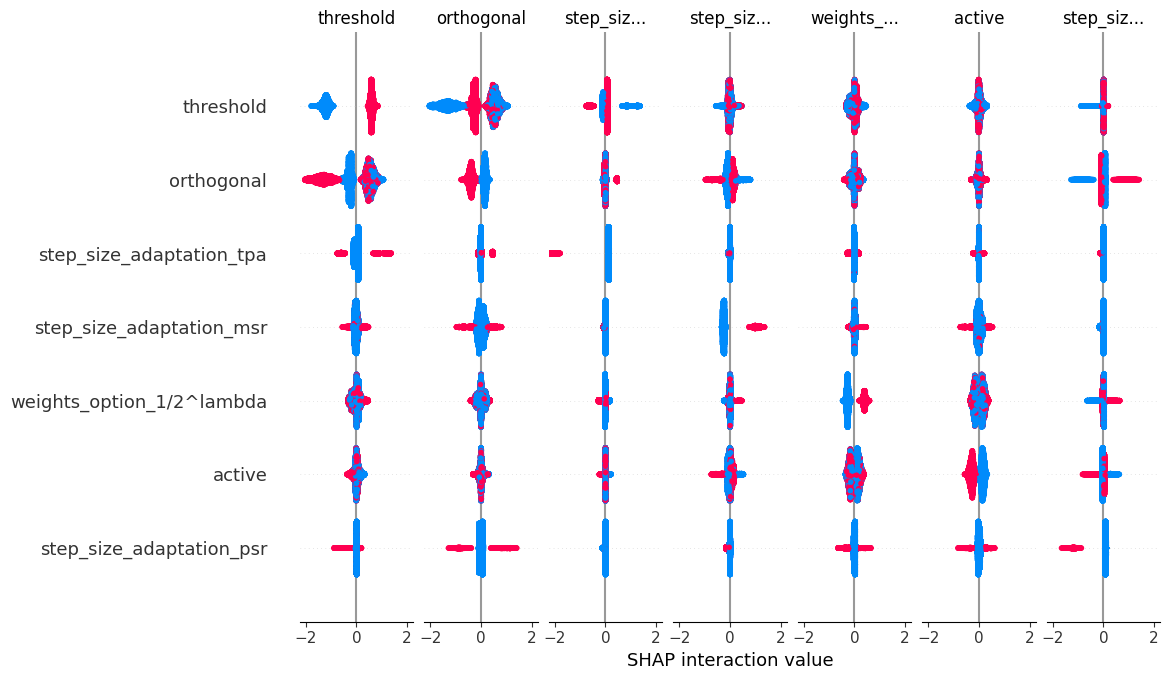

[0]	test-logloss:0.47072
[1000]	test-logloss:0.03019
[2000]	test-logloss:0.02155
[3000]	test-logloss:0.01767
[4000]	test-logloss:0.01504
[4999]	test-logloss:0.01288


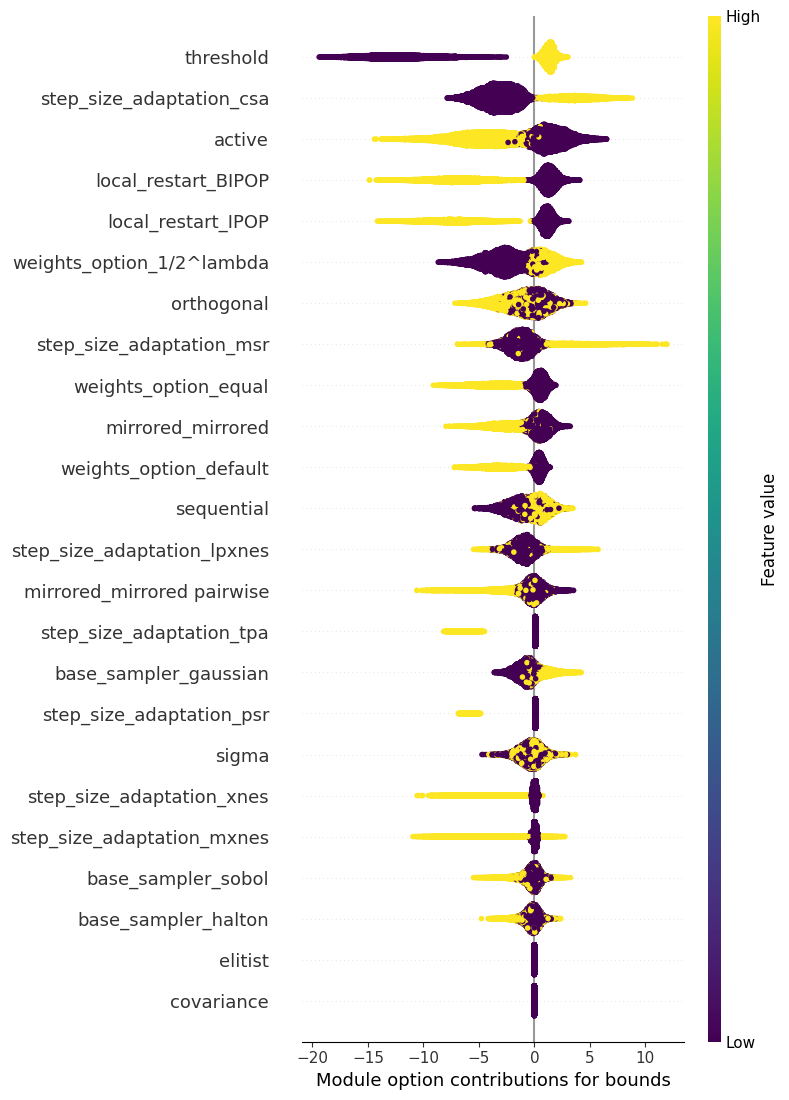

<Figure size 640x480 with 0 Axes>

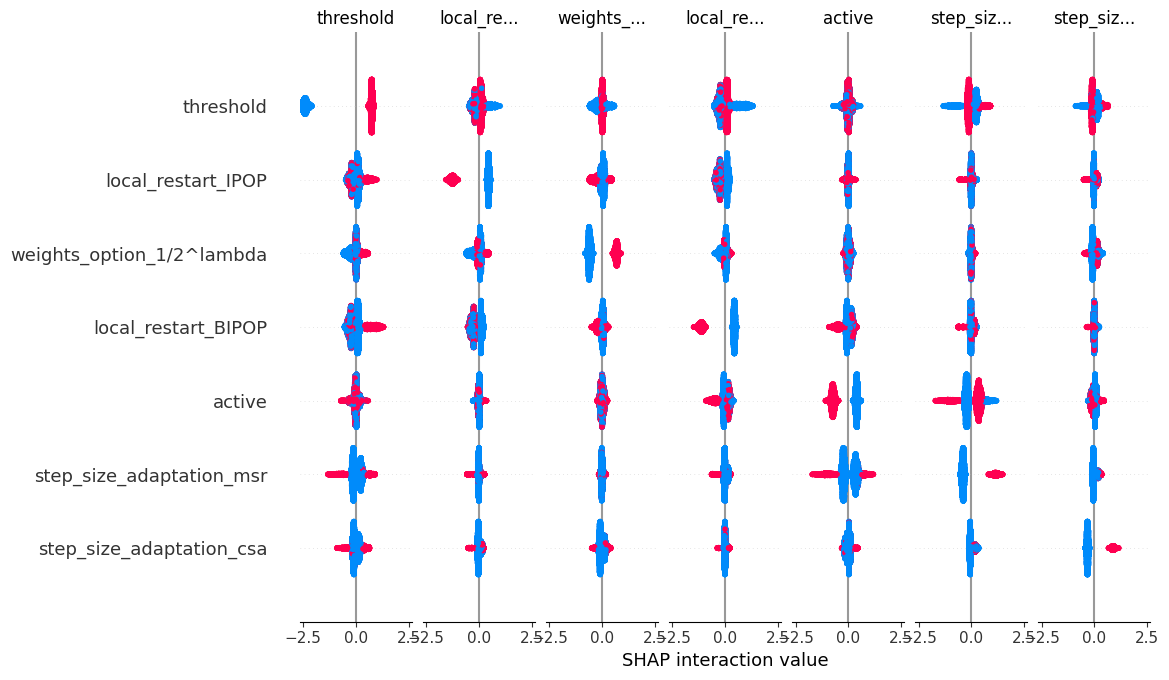

[0]	test-logloss:0.59028
[1000]	test-logloss:0.21020
[2000]	test-logloss:0.18695
[3000]	test-logloss:0.17537
[4000]	test-logloss:0.16846
[4999]	test-logloss:0.16526


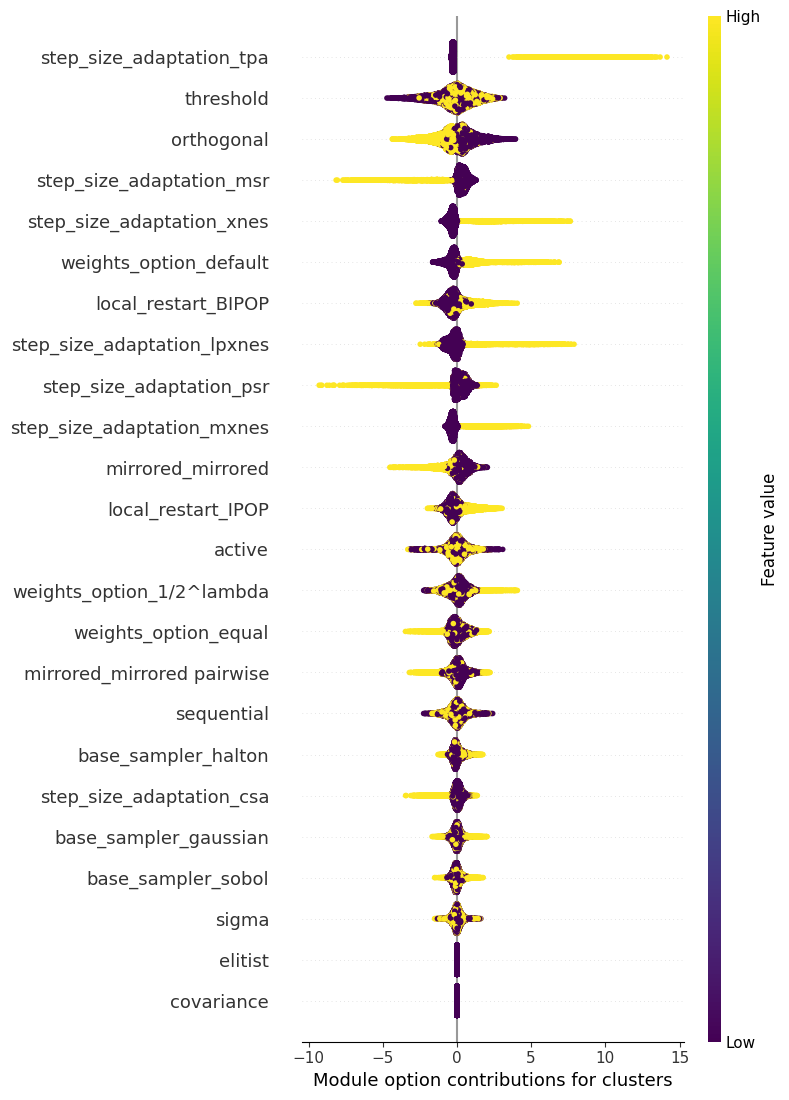

<Figure size 640x480 with 0 Axes>

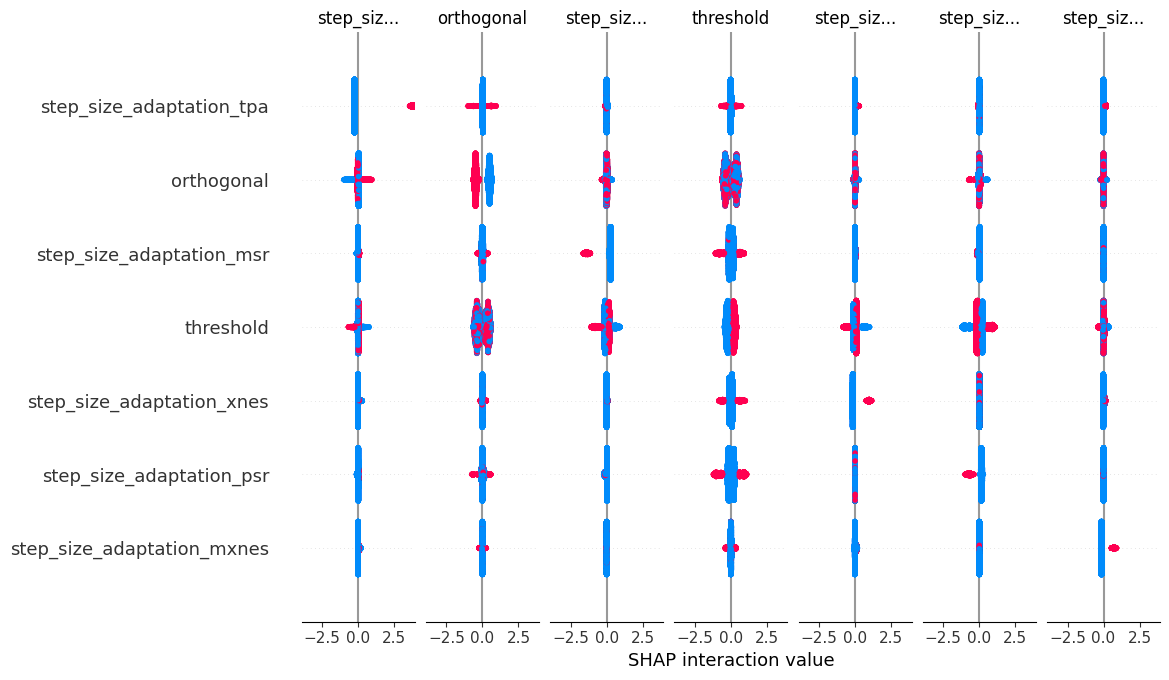

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import xgboost
from sklearn.model_selection import train_test_split

X_sub = pd.get_dummies(bias_sub[features])
y_hat_sub = bias_sub[["unif", "centre", "disc", "bounds", "clusters"]].copy()
y_sub = np.argmax(y_hat_sub, axis=1)
y_bias_sub = y_hat_sub['centre']

y_bias_sub = y_bias_sub.fillna(0)
#y_bias_sub = 1 - y_bias_sub
X_sub = X_sub.fillna(0)

# create a train/test split
#X_train, X_test, y_train, y_test = train_test_split(X_sub, y_bias_sub, test_size=0.2, random_state=42)

for idx, biastype in enumerate(list(y_hat_sub.columns)):
    y_bias = y_sub == idx

    # create a train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_bias, test_size=0.2, random_state=42)
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    xgb_full = xgboost.DMatrix(X_sub, label=y_bias)

    # params = {"max_depth": 4, "objective": "binary:logistic", "subsample": 0.5} #"eta": 0.002, 
    # model_train = xgboost.train(
    #     params, xgb_train, 1000, evals=[(xgb_test, "test")], verbose_eval=1000
    # )

    # train final model on the full data set
    params = {"max_depth": 4, "objective": "binary:logistic", "subsample": 0.8} #"eta": 0.002, 
    model = xgboost.train(
        params, xgb_full, 5000, evals=[(xgb_test, "test")], verbose_eval=1000
    )

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_sub)
    order = list(X_sub.columns.values)
    col2num = {col: i for i, col in enumerate(X_sub.columns)}
    order = list(map(col2num.get, order))
    shap.plots.beeswarm(
                        explainer(X_sub),
                        show=False,
                        order=order,
                        max_display=len(X_sub.columns),
                        color=plt.get_cmap("viridis"),
                    )
    plt.tight_layout()
    plt.xlabel(
        f"Module option contributions for {biastype}"
    )
    plt.savefig(f"bias_results/shapbias-sub-{biastype}-10.png")
    plt.show()
    plt.clf()
    
    if False:
        ## interaction plots
        #pred_interactions
        shap_interaction_values = explainer.shap_interaction_values(
            X_sub, tree_limit=50
        )
        shap.summary_plot(shap_interaction_values, X_sub, show=False, color=plt.get_cmap("viridis"))
        plt.savefig(f"bias_results/shapbias-sub-interactions-{biastype}.png")
        plt.show()
        plt.clf()